In [118]:
import copy
import itertools
import pprint
import matplotlib.pyplot
import pandas as pd
import shapely.geometry
from pandas import DataFrame
import numpy as np
import math
from scipy.spatial import distance
import json
import ml.RL.bicycle_model
from analysis.lap_difference_analyzer import *
from analysis.log_file_analyzer import *
from ml.RL.bicycle_model import BicycleKinematicModel
from shapely.geometry import LineString
from shapely.geometry.polygon import LinearRing

In [4]:
reference_df = log_to_dataFrame("../test_data/kartfinal36pr3r.csv")
normalize_logs(reference_df)

traces_df = log_to_dataFrame("../test_data/200629130554_gps.log")
normalize_logs(traces_df)

laps = separate_laps(traces_df, reference_df)

reference_df['LAT'] = reference_df['LAT'].apply(lambda deg: degrees2kilometers(deg) * 1000)
reference_df['LON'] = reference_df['LON'].apply(lambda deg: degrees2kilometers(deg) * 1000)
reference_df['CRS'] = reference_df['CRS'].apply(lambda deg: np.deg2rad(deg))
# reference_df['CRS'] = reference_df['CRS'].apply(lambda deg: deg if not deg > math.pi else deg - 2*math.pi)

traces_df['LAT'] = traces_df['LAT'].apply(lambda deg: degrees2kilometers(deg) * 1000)
traces_df['LON'] = traces_df['LON'].apply(lambda deg: degrees2kilometers(deg) * 1000)
traces_df['CRS'] = traces_df['CRS'].apply(lambda deg: np.deg2rad(deg))
# traces_df['CRS'] = traces_df['CRS'].apply(lambda deg: deg if not deg > math.pi else deg - 2*math.pi)

Steering angle: 0.0,
 CurrentCoords: (1953455.8698890596, 5342830.671894487),
 New State: (1953453.8683025537, 5342828.4372465378, 0.0, 3.9819515919105193),
 Line: LINESTRING (1953455.86988906 5342830.671894487, 1953453.868302554 5342828.437246538)

Steering angle: 0.017453292519943295,
 CurrentCoords: (1953455.8698890596, 5342830.671894487),
 New State: (1953453.8770155145, 5342828.4295331854, 0.05235987755982989, 4.016868814857163),
 Line: LINESTRING (1953455.86988906 5342830.671894487, 1953453.877015515 5342828.429533185)

Steering angle: 0.03490658503988659,
 CurrentCoords: (1953455.8698890596, 5342830.671894487),
 New State: (1953453.8858230335, 5342828.4219171349, 0.10471975511965978, 4.051849979534024),
 Line: LINESTRING (1953455.86988906 5342830.671894487, 1953453.885823034 5342828.421917135)

Steering angle: 0.05235987755982989,
 CurrentCoords: (1953455.8698890596, 5342830.671894487),
 New State: (1953453.8947295377, 5342828.4143950501, 0.15707963267948966, 4.0869596016096645)

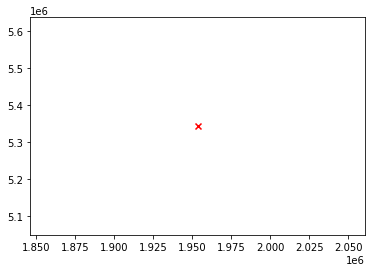

In [137]:
def n_wise(iterable, n):
    return zip(*(itertools.islice(iterable, i, None) for i in range(n)))

def get_angle(p0, p1, p2):
    ''' compute angle (in degrees) for p0p1p2 corner
    Inputs:
        p0,p1,p2 - points in the form of [x,y]
    '''
    v0 = np.array(p1) - np.array(p0)
    v1 = np.array(p2) - np.array(p1)

    angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
    return np.degrees(angle)

def find_nearest_coord(array, value):
  return min(array, key=lambda c: (c[0]- value[0])**2 + (c[1]-value[1])**2)

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2, positive=False):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
    """
    angle =  atan2( np.linalg.det(np.array(v1+v2).reshape((2,2))), np.dot(v1, v2) )
    if positive and angle < 0:
        angle += 2 * math.pi
    return angle

def getNewSteeringAngle(lap, reference_lap):
    points = [tuple(x) for x in lap[['LON', 'LAT']].to_numpy()]
    reference_points = [tuple(x) for x in reference_lap[['LON', 'LAT']].to_numpy()]
    reference_polygon = LinearRing(reference_df[['LON', 'LAT']].values)

    possible_angles = [0]
    for i in range(1,30):
        possible_angles.append(i)
    for i in range(1,30):
        possible_angles.append(-i)

    # for i in range(len(reference_points)):
    #     x,y = reference_points[i]
    #     matplotlib.pyplot.scatter(x, y, marker="x", color="blue")

    for i in range(len(points)):
        starting_point = points[i]
        x,y = starting_point
        xt, yt = reference_points[0]
        nearest_vector = (xt-x, yt-y)
        starting_heading_angle = angle_between((1,0), nearest_vector, True)
        model = BicycleKinematicModel(x=starting_point[0],
                                      y=starting_point[1],
                                      heading_angle=starting_heading_angle,
                                      steering_angle=0)
        actual_index = 0
        while True:
            actual_state = model.get_state()
            current_x, current_y, steering_angle, heading_angle = actual_state
            # print("Actual state: {}".format(actual_state))
            # print("Actual heading angle: {}".format(math.degrees(heading_angle)))
            matplotlib.pyplot.scatter(current_x, current_y, marker="x", color="red")

            found_next_angle = False
            target_angle = heading_angle
            turn_angle = 0
            lowest_distance = math.inf
            for j in range(len(possible_angles)):
                copied_model = BicycleKinematicModel(current_x, current_y, steering_angle, heading_angle)
                angle = math.radians(possible_angles[j])

                copied_model.change_state(1, angle)
                copied_model.change_state(1, angle)
                copied_model.change_state(1, angle)

                new_x, new_y, new_steering_angle, new_heading = copied_model.get_state()
                new_distance = shapely.geometry.Point([new_x,new_y]).distance(reference_polygon)
                line = LineString([[current_x,current_y], [new_x, new_y]])
                print("Steering angle: {},\n CurrentCoords: {},\n New State: {},\n Line: {}\n".format(angle, (current_x, current_y), copied_model.get_state(), line))
                is_near_reference = reference_polygon.intersects(line)
                if lowest_distance > new_distance and is_near_reference and math.radians(30) > new_steering_angle > math.radians(-30):
                    lowest_distance = new_distance
                    turn_angle = angle

            print("Steering by: {}".format(turn_angle))
            model.change_state(1, turn_angle)
            actual_index += 1

            if actual_index > 0:
                break

            # for j in range(len(possible_angles)):
            #     # Handle positive angle then negative
            #     current_angle = heading_angle + math.radians(possible_angles[j]) + steering_angle
            #     target_x, target_y = (cos(current_angle), sin(current_angle))
            #
            #     line = LineString([[x,y],[x+10*target_x, y+10*target_y]])
            #     intersection = reference_polygon.intersection(line)
            #
            #     if not intersection.is_empty:
            #         found_next_angle = True
            #         target_angle = current_angle
            #         break
            #
            # if not found_next_angle:
            #     print("Couldn't find next angle")
            #     break
            #
            # print("Next angle: {}".format(math.degrees(target_angle)))
            # model.change_state(0.9, (target_angle - heading_angle))
        break


# Postup algoritmu:
# Zobrat koordinaty krivky
# Pre kazdy bod ako zaciatocny spravit cele kolecko
# Vypocet pre bod:
# Zobrat bod, vyratat uhol medzi aktualnym a najblizsim na referencnej, (tento uhol je novy steering command)
# spriemerovat uhly na rovnakom indexe (pozor, bude treba rotovat kolecka).
for value in n_wise(laps, 2):
    lap = traces_df.iloc[value[0]:value[1]]
    getNewSteeringAngle(lap, reference_df)
    break